# CCD spectrometer
## Sulfur: 
* ### Fit one Stokes and the corresponding Anti-Stokes peak, 
* ### calculate ratio of intensities for different laser intensities, 
* ### determine temperature of probe.

All counts are transformed to rates. 

Background is then subtracted, polarization is assumed to be horizontally (0 deg) 
and corrected for the corresponding term.

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [26]:
from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = True # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        
fig_dir = "./figures/"
npy_dir = "./npy/"


color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
        
xlim_global = (420, 620) # Full range
xlim_global = (500, 590) # interesting range

In [83]:
# NOT SPECIFIC 

def uc_str(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

In [10]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((np.pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

def linear(x, a, b):
    return (a*x + b)

In [11]:
# RAMAN SPECIFIC
def t_avg(filename):
    """
    Get integration time and number of measurements
    """
    f = open("data/" + filename + ".txt", encoding='cp1252')
    lines = f.readlines()
    f.close()
    t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
    avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from
    return t, avg

def lamb_to_cm(lamb_stokes):
    """
    Converts Raman peaks in nm into wavenumber (in cm^-1) of corresponding vibrational mode
    """
    #lamb_laser = 532 # nm, Nd:Yag frequency doubled
    lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0] # measured laser wavelength
    dnu_cm = abs(1 / lamb_laser - 1 / lamb_stokes) * 10**7
    return(dnu_cm)

def cm_to_lamb(dnu_cm):
    """
    Converts  wavenumber (in cm^-1) of vibrational mode into corresponding Stokes 
    peak in nm (for Nd:Yag laser)
    """
    #lamb_laser = 532 # nm, Nd:Yag frequency doubled
    lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0] # measured laser wavelength
    lamb_stokes = 1 / (1 / lamb_laser - dnu_cm * 10**-7) 
    lamb_anti_stokes =  1 / (1 / lamb_laser + dnu_cm * 10**-7) 
    return(lamb_stokes, lamb_anti_stokes)

## Sulfur
* Get data
* Fit Stokes and Anti-Stokes peak for each laser intensity.
* Notch filter is plotted in order to see its influence.

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


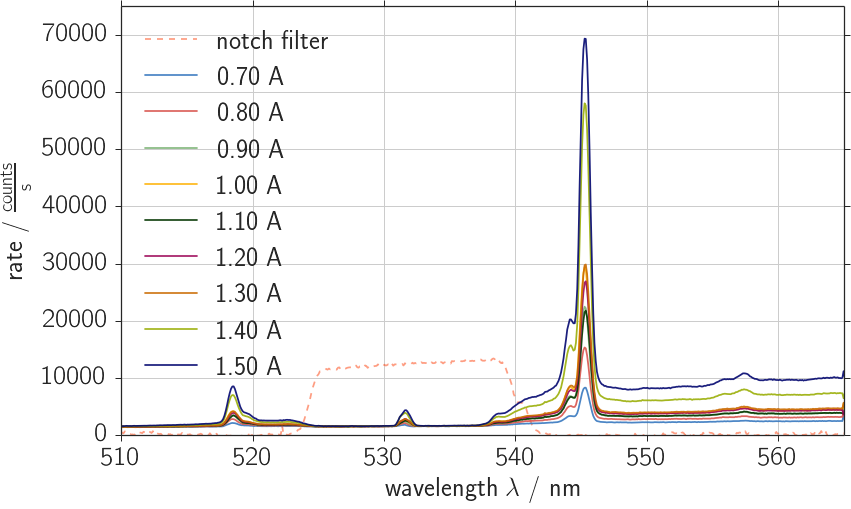

In [29]:
corr = np.load(npy_dir + 'ccd_corr0.npy') # Correction factor for polarization
rate_bg = np.load(npy_dir + 'ccd_rate_bg.npy')
rate_bg_e = np.load(npy_dir + 'ccd_rate_bg_e.npy')

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Sulfur spectra')
    
I_laser_all = [70, 80, 90, 100, 110, 120, 130, 140, 150]
labels = ['%.2f A'%(I_l * 0.01) for I_l in I_laser_all]
#I_laser_all = [130]
    
# display notch filter in order to identify its effects
notch = np.load("npy/ccd_notch.npy")
ax.plot(x, notch * 0.3, "--", c=colors[-1], alpha = 0.5, label='notch filter')

x0s = []
As = []
for i, I_laser, label in enum(I_laser_all, labels):
    filename = "ccd_s_" + str(I_laser).zfill(3)
    t, avg = t_avg(filename)
     
    # Data
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    y = y / t - rate_bg
    y_e = y_e / t - rate_bg_e
    
    # Correction for polarization
    y = corr * y
    y_e = corr * y_e
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)
    
    x_ranges = [[545, 549],
                [510, 519]]
    p0s = np.array([[545.5, 0.2, 20000, 3500],
                    [518, 0.2, 5000, 200]])

    for j, x_range, p0 in enum(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
        x0s.append(c1[0])
        As.append(c1[2])

'''        
    # Peak fit
    # Stokes peak
    x_range1 = [545, 549]   # lower and upper bound
    p0 = np.array([545.5, 0.2, 20000, 3500])
    x_fit1, fit_peak1, c1 = bw_fit(x, y_e, x_range1, p0, fit=True)
    #ax.plot(x_fit1, fit_peak1, "--", c=colors[i], label='Stokes')
    x0s.append(c1[0])
    As.append(c1[2])

    # Anti-Stokes peak
    x_range2 = [510, 519]   # lower and upper bound
    p0 = np.array([518, 0.2, 5000, 200])
    x_fit2, fit_peak2, c2 = bw_fit(x, y_e, x_range2, p0, fit=True)
    #ax.plot(x_fit2, fit_peak2, "--", c=colors[i], label='Anti-Stokes')

    # Collect intensities
    As.append([c_i[2] for c_i in [c1, c2]])
    lambs.append([uc.ufloat(c_i[0].n, c_i[1].n) for c_i in [c1, c2]])
'''

ax.set_xlim(xlim_global)
ax.set_xlim(510, 565)
ax.set_ylim(0, 75000)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_sulfur_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

#### The intensity is supposed to follow the relationship

$\frac{I_{AS}}{I_{S}}  = \left( \frac{\nu_L + \Delta \nu}{\nu_L - \Delta \nu} \right)^4 e^{-\frac{h \Delta \nu}{k_B T}}$

and should thus be constant for all intensities (ignoring warming due to the laser...). We take the mean value of all measured ones.

Get Laser wavelength, Raman peak wavelength!

\cellcolor{LightCyan}$0.70$ A & $7462 \pm 6$ & $1096 \pm 5$ & $(146.8 \pm 0.6)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$0.80$ A & $15187 \pm 7$ & $2004 \pm 4$ & $(132.0 \pm 0.3)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$0.90$ A & $22940 \pm 8$ & $2952 \pm 4$ & $(128.7 \pm 0.2)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$1.00$ A & $30256 \pm 8$ & $3834 \pm 4$ & $(126.7 \pm 0.2)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$1.10$ A & $22607 \pm 7$ & $2866 \pm 5$ & $(126.8 \pm 0.2)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$1.20$ A & $28225 \pm 8$ & $3552 \pm 5$ & $(125.9 \pm 0.2)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$1.30$ A & $31637 \pm 8$ & $3939 \pm 5$ & $(124.5 \pm 0.2)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$1.40$ A & $62397 \pm 9$ & $7582 \pm 5$ & $(121.5 \pm 0.1)\mathrm{e}-3$   \\
\cellcolor{LightCyan}$1.50$ A & $77655 \pm 10$ & $9649 \pm 5$ & $(124.2 \pm 0.1)\mathrm{e}-3$   \\

0.129 \pm 0.007


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


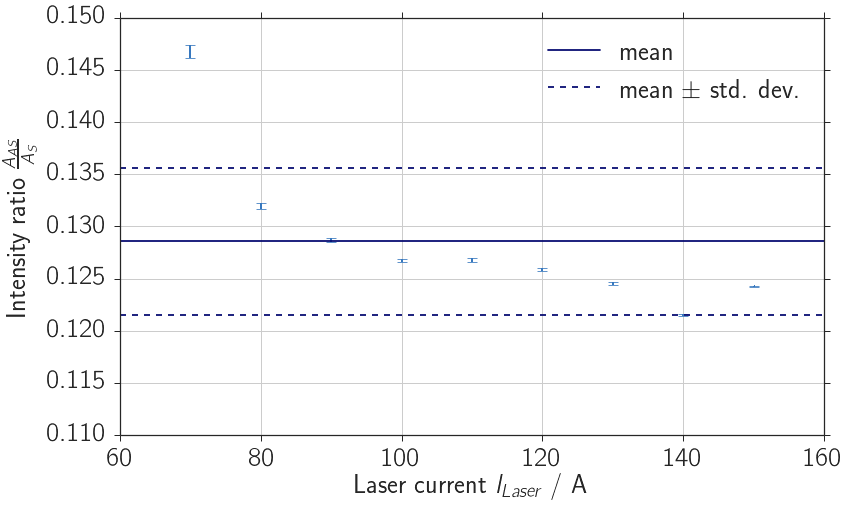

In [90]:
intensities = np.array(As).reshape(9, 2).T # stokes and anti-stokes
A_ratio = intensities[1] / intensities[0]
y = un.nominal_values(A_ratio)
sy = un.std_devs(A_ratio)

mean_ratio = np.mean(y)
std_ratio = np.std(y)
m_r_e = uc.ufloat(mean_ratio, std_ratio)

fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Ratio of intensities of Stokes and AS peaks (sulfur)')

ax.errorbar(I_laser_all, y, xerr=None, yerr=sy, fmt=',', c=colors[0], 
            elinewidth=2.0, capsize=5.2, capthick=0.8)
ax.plot([60, 160], [mean_ratio]*2, '-', c=colors[8], label='mean')
ax.plot([60, 160], [mean_ratio - std_ratio]*2, '--', c=colors[8], label='mean $\pm$ std. dev.')
ax.plot([60, 160], [mean_ratio + std_ratio]*2, '--', c=colors[8])

ax.set_xlim(60, 160)
ax.set_ylim(0.11, 0.15)
ax.set_xlabel('Laser current $I_{Laser}$ / A')
ax.set_ylabel('Intensity ratio $\\frac{A_{AS}}{A_{S}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_temp_rate"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

    
def uc_str_e3(c):
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    digit = 4
    c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

# Print latex table
for I_l, Is, Ias, A_rat in zip(labels, intensities[0], intensities[1], A_ratio):
    print("\cellcolor{LightCyan}$%s$ A & $%s$ & $%s$ & $%s$   \\\\"%(
            I_l[:-2], uc_str(Is), uc_str(Ias), uc_str_e3(A_rat)))
    
print('/n Mean intensity ratio: ', uc_str(uc.ufloat(mean_ratio, std_ratio)))

In [44]:
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

lamb_both = np.mean(np.array(lambs).T, 1) # means of wavelengths of stokes and antistokes peaks

d_lin = np.load(npy_dir + 'ccd_calibration.npy')
lamb_both = linear(lamb_both, *d_lin)

nu_l = c / lamb_laser
dnu = np.mean(abs(c / lamb_both - nu_l)) # in Hz!!!

# in cm^-1: nu_l, dnu * 10**7
T = -(h * dnu * 10**9) / (k * un.log(m_r_e * ((nu_l - dnu) / (nu_l + dnu))**4))

print('wavenumber of laser = ' + uc_str(nu_l * 10**-2) + ' cm^{-1}')
print('\Delta \\nu = ' + uc_str(dnu * 10**-2) + ' cm^{-1}')
print('Temperatur T = ' + uc_str(T) + ' K')
print('Temperatur T = ' + uc_str(T - 273.15) + ' ^\circ C')

wavenumber of laser = 5634 \pm 3 cm^{-1}
\Delta \nu = 141.7 \pm 1.2 cm^{-1}
Temperatur T = 302 \pm 8 K
Temperatur T = 29 \pm 8 ^\circ C


In [43]:
lamb_all = np.array(x0s).reshape(9, 2)

d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD

lamb_mean = np.mean(lamb_all, 0) 
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_mean - 1 / lamb_laser) * 10**7

lits = np.array(['bla', 'blub']) # S, S, S, AS, AS for CCl4

for i, x0, dnu_cm, lit in enum(lamb_mean, lamb_to_cm(lamb_mean), lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%s$   \\\\"%(
            i+1, uc_str(x0), uc_str(dnu_cm), lit))
    

\cellcolor{LightCyan}$1$ & $545.6 \pm 0.3$ & $463 \pm 13$ & $bla$   \\
\cellcolor{LightCyan}$2$ & $518.8 \pm 0.3$ & $482 \pm 14$ & $blub$   \\
